<a href="https://colab.research.google.com/github/sushvij/Capstone-EDA-v2/blob/main/unsupervised_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect colab to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# for loading/processing the images  
from keras_preprocessing.image import load_img 
from keras_preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [4]:
path = r"/content/drive/MyDrive/Capstone/DATASET"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
cells = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            cells.append(file.name)


In [5]:
cells[:10]

['3151.png',
 '83.png',
 '735.png',
 '7278.png',
 '746.png',
 '518.png',
 '8204.png',
 '758.png',
 '8206.png',
 '836.png']

In [6]:
dir_list = os.listdir(path)

In [7]:
df = pd.DataFrame(dir_list)

In [8]:
df.columns = ['label']

In [9]:
df.to_csv('cell_labels.csv', index=False)

In [10]:
# load the model first and remove the output layer by passing as an argument -2
# this makes the output a fully connected layer of 4096 nodes, i.e. our feature vector
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


In [11]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [12]:
data = {}

# lop through each image in the dataset
for cell in cells:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(cell,model)
        data[cell] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(984, 1, 4096)

# reshape so that there are 984 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(984, 4096)

# get the unique labels (from the cell_labels.csv)
df = pd.read_csv('cell_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

1/1 [==============================] - 0s 17ms/step


In [13]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [14]:
print("original shape:", feat.shape)
print("Components after PCA", x.shape)

original shape: (984, 4096)
Components after PCA (984, 100)


In [15]:
kmeans = KMeans(n_clusters=4, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=4, random_state=22)

In [16]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [55]:
df_cluster0 = groups[0]

In [56]:
df_cluster1 = groups[1]

In [57]:
df_cluster2 = groups[2]

In [58]:
df_cluster3 = groups[3]

In [ ]:
df.loc[:,"cluster"] = kmeans.labels_

In [40]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 119 to 30


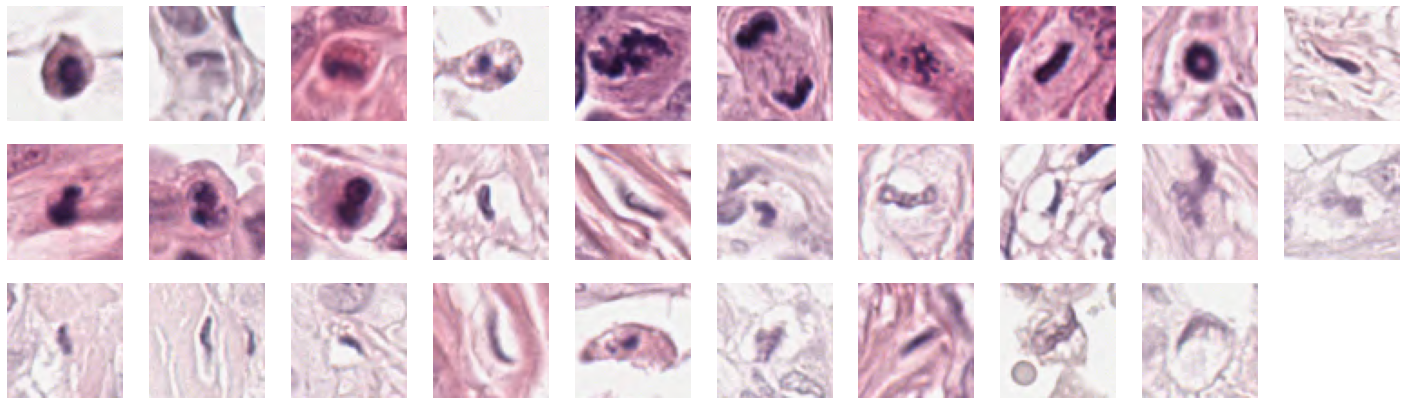

In [45]:
view_cluster(0)

Clipping cluster size from 323 to 30


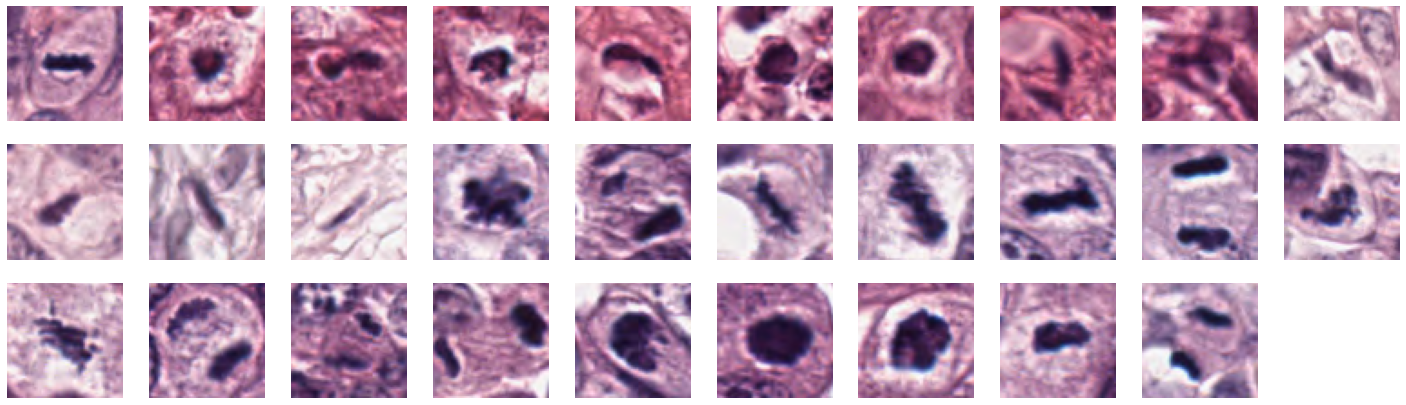

In [46]:
view_cluster(1)

Clipping cluster size from 313 to 30


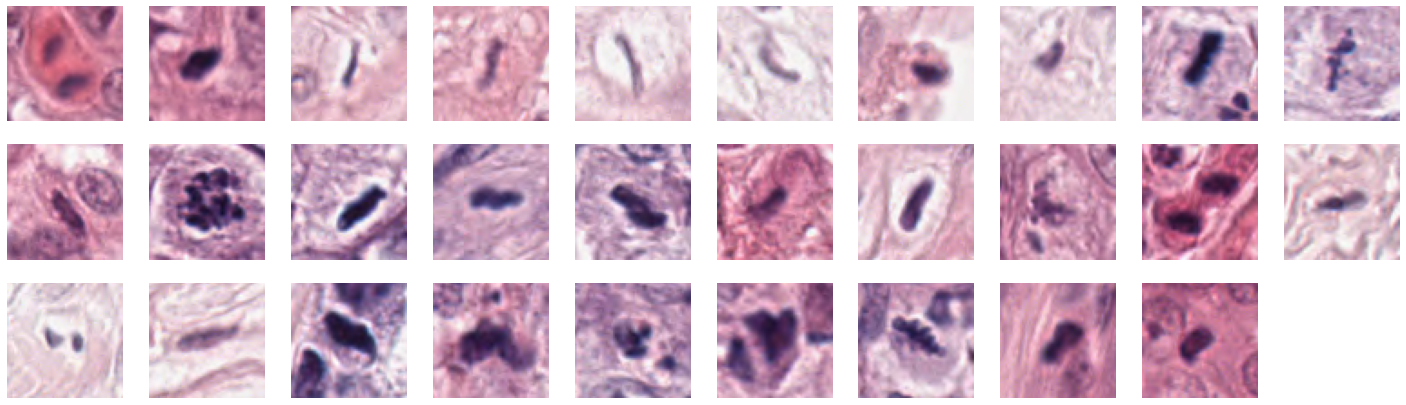

In [47]:
view_cluster(2)

Clipping cluster size from 229 to 30


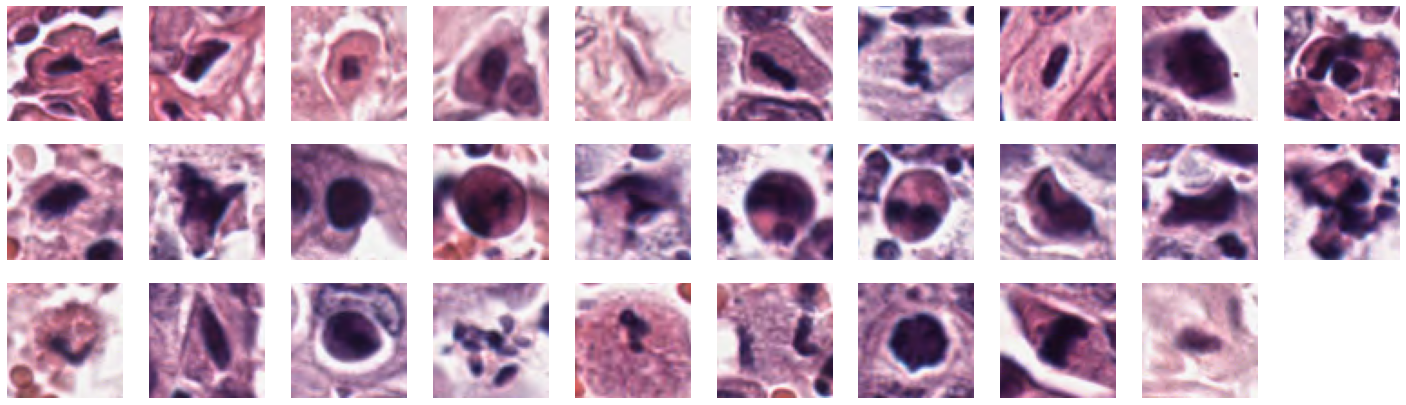

In [48]:
view_cluster(3)

In [42]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(4, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

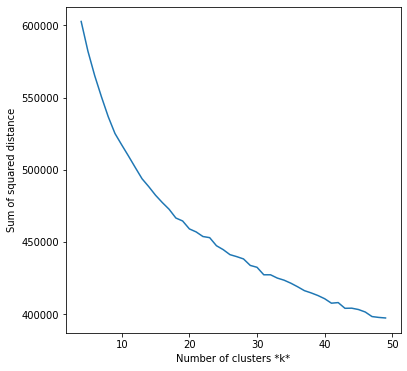

In [43]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');


### CNN All The Way - Please see Resnet and VGG model files!

In [61]:
!pip install TensorFlow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import numpy as np
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.set_random_seed(2022)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu" , input_shape = (180,180,3)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu"),  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(550,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.1,seed = 2022),
    tf.keras.layers.Dense(400,activation ="relu"),
    tf.keras.layers.Dropout(0.3,seed = 2022),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.Dropout(0.4,seed = 2022),
    tf.keras.layers.Dense(200,activation ="relu"),
    tf.keras.layers.Dropout(0.2,seed = 2022),
    tf.keras.layers.Dense(5,activation = "softmax")   #Adding the Output Layer
])